# Sez.0 Obbiettivo

L'obbiettivo del progetto è costruire un circuito quantistico per la compressione e ricostruzione di uno stato a diversi tassi di compressione. La compressione avviene mediante un circuito ibrido classico-quantistico, in cui lo stato iniziale viene manipolato da un circuito parametrico di compressione (encoder), si calcola la fedeltà allo stato di partenza attraverso una procedura detta Swap Test, si ottiene quindi una funzione costo che può essere minimizzata da un ottimizzatore classico.

# Sez.1 Teoria

## Sez 1.1 Setting

<div style="text-align:center">
    <img src="./immagini/setting.png" alt="Alt Text" width="1000">
    <p><em>Figure 1</em></p>
</div>

Il circuito opera su $n$ qubit che codificano lo stato originale $|\psi_{AB}\rangle$ , che verranno ridotti a $m$ qubit durante la compressione; i restanti $n-m$ qubit costituiscono il trash space, che sarà fondamentale per la misura della funzione costo. Gli stati su cui si andrà a operare sono $|\Psi\rangle=|\psi_{AB}\rangle\otimes|\psi_{B'}\rangle\otimes|\psi_{aux}\rangle$ ovvero lo stato da comprimere, $|\psi_{B'}\rangle=|0\rangle^{\otimes m}$ e $|\psi_{aux}\rangle$ usati per una operazione di misura detta swap test.

Possiamo considerare il circuito encoder come un generico operatore unitario $U(\theta_i)_{AB}$ e quindi il decoder come il corrispondente hermitiano coniugato $U(\theta_i)^\dagger_{AB'}$, con la differenza che il decoder agisce sullo spazio latente (cioè quello dello stato compresso) e sul reference space (quello dello stato di reference $a\psi{B'}$)


<div style="text-align:center">
    <img src="./immagini/schema1.png" alt="Alt Text" width="600">
</div>


La Loss più naturale per questo learner sarebbe la fedeltà tra lo stato originale e quello ricostruito $\mathcal{L}= \langle \psi_{AB} | \rho^{out} | \psi_{AB} \rangle $ ,
dove $\rho^{out}= U(\theta_i)^\dagger_{AB'} Tr_{B}\big[U(\theta_i)_{AB} |\Psi\rangle\langle\Psi| U(\theta_i)^\dagger_{AB} \big] U(\theta_i)_{AB'} $,
tuttavia siccome lo stato originale non sarà più accessibile dopo la ricostruzione si deve trovare un'alternativa. Se consideriamo l'intero sistema possiamo trovare un modo:

\begin{array}{ll}
F(|\psi_{AB}\rangle\otimes|a_{B'}\rangle,U(\theta_i)^\dagger_{AB}V_{BB'}U(\theta_i)_{AB}|\psi_{AB}\rangle\otimes|a_{B'}\rangle)=\\ \\
=F(U(\theta_i)_{AB}|\psi_{AB}\rangle\otimes|a_{B'}\rangle,V_{BB'}U(\theta_i)_{AB}|\psi_{AB}\rangle\otimes|a_{B'}\rangle)=\\ \\
=F(|\psi'_{AB}\rangle\otimes|a_{B'}\rangle,|\psi'_{AB'}\rangle\otimes|a_{B}\rangle)
\end{array}

dove $V_{BB'}$ è l'operatore che scambia i sistemi B e B'.
A questo punto se si prende la traccia nel sistema B', cioè il trash space, si ritorna alla $\mathcal{L}_1$, se invece si traccia su A e B, quindi lo spazio latente e il reference space,  rimane $\mathcal{L}_2=F(|a_{B'}\rangle, \rho'_{B'} )$, cioè la fedeltà tra il reference state e il trash state $\rho'_{B'}=Tr_{AB}\big[|\psi'_{AB}\rangle\langle\psi'_{AB}|\big] $.
Il principale inconveniente di questa soluzione è che $\mathcal{L}_2 \geq \mathcal{L}_1$, quindi è possibile che la performance che viene effettivamente misurata sia sovrastimata, tuttavia nel momento in cui una delle due è massima lo è anche l'altra, in quanto gli stati comparati sono identici.


## Sez1.2 SWAP TEST

<div style="text-align:center">
    <img src="./immagini/schema_SWAPTEST.png" alt="Alt Text" width="1000">
    <p><em>Figure 2</em></p>
</div>

La procedura che consente di misurare la Loss consta di una sequenza di entanglement e misura in base computazionale, si inizia con due stati da comparare, che chiameremo genericamente $|\psi\rangle$ e $|\phi\rangle$ e un qubit ancella in $|0\rangle$ oggetto della misura. Si agisce con una porta H sulla ancella, poi la si usa come qubit di controllo in una porta CSWAP su due qubit corrispondenti di $|\psi\rangle$ e $|\phi\rangle$, ripetendo l'operazione fino a scambiare del tutto i due stati, si opera nuovamente con H sull'ancella e infine si misura la medesima in base computazionale. Il risultato di tale procedura è il seguente:

\begin{array}{ll}
|0\rangle \otimes |\psi\rangle \otimes |\phi\rangle \rightarrow \frac{1}{\sqrt{2}}[|0\rangle+|1\rangle]\otimes |\psi\rangle \otimes |\phi\rangle =\\
\frac{1}{\sqrt{2}}[|0\rangle \otimes |\psi\rangle \otimes |\phi\rangle+|1\rangle \otimes |\psi\rangle \otimes |\phi\rangle]\rightarrow \\
\frac{1}{\sqrt{2}}[|0\rangle \otimes |\psi\rangle \otimes |\phi\rangle+|1\rangle \otimes |\phi\rangle \otimes |\psi\rangle]\rightarrow\\
\frac{1}{2}[|0\rangle|\psi\rangle|\phi\rangle+|1\rangle|\psi\rangle|\phi\rangle+|0\rangle|\phi\rangle|\psi\rangle-|1\rangle|\phi\rangle|\psi\rangle]=\\
\frac{1}{2}|0\rangle[|\psi\rangle|\phi\rangle+|\phi\rangle|\psi\rangle]+\frac{1}{2}|1\rangle[|\psi\rangle|\phi\rangle-|\phi\rangle|\psi\rangle]
\end{array}
Ora, la probabilità di misurare $0$ è
\begin{array}{ll}
\frac{1}{4}\big[ \langle \psi \phi|+\langle \phi \psi|\big]\big[ |\psi\phi\rangle+|\phi\psi\rangle \big] =
\frac{1}{2}+\langle \psi \phi|\phi\psi\rangle\langle \phi \psi|\psi\phi\rangle=\\
\frac{1}{2}+\big|\langle \psi \phi|\phi\psi\rangle\big|^2=\frac{1}{2}+F(|\psi\rangle, |\phi\rangle)
\end{array}

dunque misurando ripetutamente lo stesso circuito possiamo ottenere una stima di questa probabilità come frequenza relativa degli zeri su tutti i tentativi.


# Sez2 Implementazione

Per implementare il circuito di cui sopra si è usato Qiskit, una libreria Python per la programmazione di circuiti quantistici.

In [1]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.circuit.library import RealAmplitudes #RealAmplitudes is a variational form that can be used as ansatz
from qiskit_algorithms.optimizers import COBYLA #COBYLA is a classical optimizer
from qiskit_machine_learning.neural_networks import SamplerQNN 
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


import json
import time
import warnings

from quantum import * #importing the functions from the quantum.py file

Nel modulo quantum.py sono definite le funzioni AnsatzeBuilder, SwaptestBuilder ed EncoderBuilder che restituiscono i corrispondenti circuiti quantistici (si veda file per dettagli).

### Sez 2.1 Costruzione del Encoder

Si definiscono lo stato iniziale che si vuole comprimere (q), la dimensione dello stato compresso e la profondità del circuito parametrico RealAmplitudes associato all'encoder. Viene costruito l'encoder attraverso la funzione EncoderBuilder, che restituisce un circuito composto dal circuito parametrico RealAmplitudes seguito dal circuito che esegue lo SWAP test.

In [2]:
#Parametri
q = [0,0,1,1,1,0,0,0,0,0] #input state
EncodedStateDimension = 3
Depth = 3

#Costruisco encoder
InputStateDimension = len(q)
Encoder = EncoderBuilder(InputStateDimension, EncodedStateDimension, Depth)
#Costruisco circuito generico, resetto qubit a 0 e applico X ai qubit 2,3,4
Circuit = QuantumCircuit(Encoder.num_qubits, Encoder.num_clbits)
for i in range(Circuit.num_qubits):
    Circuit.reset(i)
for i in range(InputStateDimension):
    if q[i] == 1:
        Circuit.x(i)
Circuit.compose(Encoder, inplace=True)
#Circuit.draw('mpl', filename='circuit.png')
#Circuit.draw()

<div style="text-align:center">
    <img src="./immagini/circuit.png" alt="Alt Text" width="1000">
    <p><em>Figure 3: schema circuito completo. q = [0,0,1,1,1,0,0,0,0,0], EncodedStateDimension = 3, Depth = 3</em></p>

</div>


#### Sez 2.1.1 RealAmplitudes

Per implementare un encoder con un circuito quantistico è necessario definire l'operatore unitario $U(\theta_i)$, in modo che il numero di gate (e quindi di parametri) scali in modo polinomiale rispetto al numero di qubit di input. Una delle possibilità è quella di impiegare un circuito "modulare", in cui un circuito "modulo" viene ripetuto un certo numero di volte (Depth del circuito). Abbiamo utilizzato un circuito 2-locale, che permettesse rotazione di ogni singolo qubit ad ogni layer e entanglement tra 2 qubit adiacenti. Un semplice circuito parametrico 2-locale già presente nella libreria qiskit è RealAmplitudes (Figura 3).

<div style="text-align:center">
    <img src="./immagini/schema_RealAmplitudes.png" alt="Alt Text" width="1000">
    <p><em>Figure 4: schema circuito RealAmplitudes. InputDimension = 5, Depth = 5</em></p>
</div>

#### Sez2.1.2 SWAP TEST

Per addestrare $U(\theta_i)$ alla compressione degli stati, è necessario calcolare una funzione costo. Come descritto nella sezione 1.2 la funzione costo è misurata come la fedeltà del Trash Space al Reference Space, della stessa dimensione del precedente e composto da qubit nello stato |0>. Una volta applicato il circutio la fedeltà tra i due blocchi può essere misurata come la probabilità di misurare |0> sul qubit ancella. La funzione SwaptestBuilder ritorna il circuito di swap test con un operatore di misura sul qubit ancella verso un canale classico.

<div style="text-align:center">
    <img src="./immagini/SWAP.png" alt="Alt Text" width="500">
    <p><em>Figure 5: schema circuito SWAPTEST con Trash Space dimension = 7</em></p>
</div>

### Sez 2.2 Addestramento

<div style="text-align:center">
    <img src="./immagini/hybrid.png" alt="Alt Text" width="500">
    <p><em>Figure 6: Rappresentazione del sistema ibrido classico-quantistico per l'addestramento dell'autoencoder.</em></p>
</div>

Possiamo definire la funzione costo come la probabilità di ottenere |1> sul qubit ancella. Questo dato classico può essere passato ad un ottimizzatore classico per il calcolo di un nuovo set di parametri.

La funzione di qiskit SamplerQNN funge da interfaccia tra il circuito parametrico costruito fin ora e il simulatore di qiskit (Aer). In particolare vengono passati alla funzione circuito, parametri da ottimizzare e parametri iniziali. Gli argomento interpreter e output_shape dipendono dal circuito che stiamo passando e dal simulatore.

In [9]:
# Interprete per SamplerQNN
def identity_interpret(x):
    return x

qnn = SamplerQNN(
    circuit=Circuit, #circuito completo
    input_params=[], #guess iniziale lasciato a SamplerQNN, quindi randomici
    weight_params=Circuit.parameters, #identificato i parametri del circuito, quindi i parametri di RealAmplitudes
    interpret=identity_interpret,
    output_shape=2, #l'output del circuito può essere 1 o 0, una stringa binaria di dimensione 2
)

Definiamo cost_function che calcola la funzione costo dato un set di parametri in input. I parametri vengono passati al simulatore e otteniamo le nuove probabilità. Ogni valore di cost viene salvato in un array, che viene plottato ogni volta che la funzione viene chiamata.

In [4]:
def cost_function(params_values):
    #calcolo probabilità passando i nuovi parametri
    probabilities = qnn.forward([], params_values)
    # probabilità di ottenere 1 come output della simulazione, cioè la funzione costo
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost


#### Sez 2.2.1 COBYLA

#### Sez. 2.2.2 Risultati

In [ ]:
objective_func_vals = []
# Initialize the COBYLA optimizer
opt = COBYLA(maxiter=300)
num_parameters = Circuit.num_parameters
initial_point = np.random.rand(num_parameters)  # Set the initial parameters
print('Number of parameters in quantum circuit: ',Circuit.num_parameters)
print('Initial parameters in quantum circuit: ',initial_point)

# Perform optimization
start = time.time()
opt_result = opt.minimize(cost_function,initial_point)
#print('Cost function value:', cost_function(initial_point))
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

# TEST

In [7]:
#Parametri
q = [0,0,1,1,1] #input state
EncodedStateDimension = 3
Depth = 3

#Costruisco encoder
InputStateDimension = len(q)
Encoder = EncoderBuilder(InputStateDimension, EncodedStateDimension, Depth)
#Costruisco circuito generico, resetto qubit a 0 e applico X ai qubit 2,3,4
Circuit = QuantumCircuit(Encoder.num_qubits, Encoder.num_clbits)
for i in range(Circuit.num_qubits):
    Circuit.reset(i)
for i in range(InputStateDimension):
    if q[i] == 1:
        Circuit.x(i)
Circuit.compose(Encoder, inplace=True)
#Circuit.draw('mpl', filename='circuit.png')
#Circuit.draw()

qnn = SamplerQNN(
    circuit=Circuit, #circuito completo
    input_params=[], #guess iniziale lasciato a SamplerQNN, quindi randomici
    weight_params=Circuit.parameters, #identificato i parametri del circuito, quindi i parametri di RealAmplitudes
    interpret=identity_interpret,
    output_shape=2, #l'output del circuito può essere 1 o 0, una stringa binaria di dimensione 2
)

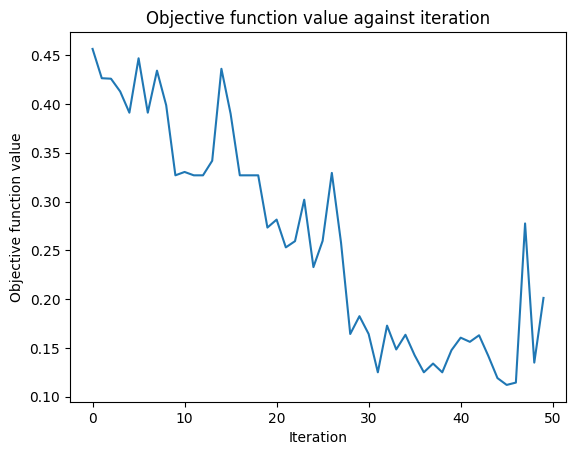

Fit in 9.09 seconds
Cost function value: 0.2012476485779778


In [11]:
def generate_random_binary_vector(dim):
    return np.random.randint(2, size=dim)

#Definisco qubit randomico di dimensione n
vector_dimension = 2
q = generate_random_binary_vector(vector_dimension)

EncodedStateDimension = 3
Depth = 3

#Costruisco encoder
InputStateDimension = len(q)
Encoder = EncoderBuilder(InputStateDimension, EncodedStateDimension, Depth)
#Costruisco circuito generico, resetto qubit a 0 e applico X ai qubit 2,3,4
Circuit = QuantumCircuit(Encoder.num_qubits, Encoder.num_clbits)
for i in range(Circuit.num_qubits):
    Circuit.reset(i)
for i in range(InputStateDimension):
    if q[i] == 1:
        Circuit.x(i)
Circuit.compose(Encoder, inplace=True)
#Circuit.draw('mpl', filename='circuit.png')
#Circuit.draw()

qnn = SamplerQNN(
circuit=Circuit, #circuito completo
input_params=[], #guess iniziale lasciato a SamplerQNN, quindi randomici
weight_params=Circuit.parameters, #identificato i parametri del circuito, quindi i parametri di RealAmplitudes
interpret=identity_interpret,
output_shape=2, #l'output del circuito può essere 1 o 0, una stringa binaria di dimensione 2
)

objective_func_vals = []
# Initialize the COBYLA optimizer
opt = COBYLA(maxiter=50)
num_parameters = Circuit.num_parameters
initial_point = np.random.rand(num_parameters)  # Set the initial parameters
print('Number of parameters in quantum circuit: ',Circuit.num_parameters)
print('Initial parameters in quantum circuit: ',initial_point)

# Perform optimization
start = time.time()
opt_result = opt.minimize(cost_function,initial_point)
#print('Cost function value:', cost_function(initial_point))
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

#print last element of objective_func_vals
print('Cost function value:', objective_func_vals[-1])

In [12]:
import numpy as np



Random Binary Vector: [0 1 0 1 1 0 1 1 1 1]
